<a href="https://colab.research.google.com/github/GoldPapaya/synonym-pathfinder/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!python -m nltk.downloader wordnet

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
import networkx as nx

Below is code to test adding nodes to a graph (to be used later).

In [ ]:
class WordNetGraph:
    def __init__(self):
        self.graph = nx.Graph()

    def add_synset_node(self, synset):
        self.graph.add_node(synset)

In [ ]:
graph = WordNetGraph()

synset1 = wn.synset('dog.n.01')
synset2 = wn.synset('bank.n.01')
graph.add_synset_node(synset1)
graph.add_synset_node(synset2)

print(f"Nodes in graph: {list(graph.graph.nodes())}")
print(f"Graph has {graph.graph.number_of_nodes()} nodes")

Nodes in graph: [Synset('dog.n.01'), Synset('bank.n.01')]
Graph has 2 nodes


Stuff below is for finding synonym candidates given a word and a depth.

In [3]:
def get_synset_neighbors(input_synset, depth):
    """
    input_synset (str): A synset name (e.g., 'trust.v.01')
    depth (int): The depth of neighbor exploration

    Returns:
    dict: Dictionary with synsets as keys and lists of lemma-associated synset names as values
    """
    result = {}
    start_synset = wn.synset(input_synset)
    # Set to keep track of synsets to process
    to_process = {start_synset}
    processed = set()
    # Process synsets up to the specified depth
    for i in range(depth + 1):
        next_to_process = set()
        for synset in to_process:
            if synset not in processed:
                # get synsets related to the synset lemmas
                lemmas = synset.lemmas()
                neighbor_synsets = set()
                for lemma in lemmas:
                    lemma_name = lemma.name()
                    for lemma_synset in wn.synsets(lemma_name, pos=synset.pos()): # restrict to same POS
                        neighbor_synsets.add(lemma_synset)

                result[synset.name()] = [n.name() for n in neighbor_synsets if n != synset]
                # add new synsets to process if depth allows further exploration
                if i < depth:
                    next_to_process.update(neighbor_synsets - processed)
                processed.add(synset)
        to_process = next_to_process
    return result

In [14]:
test_synset_string = 'bank.n.01'

# Example call
result = get_synset_neighbors(test_synset_string, 2)
for synset, neighbors in result.items():
    print(f"{synset}: {neighbors}")
print('\n', result)

bank.n.01: ['bank.n.07', 'bank.n.05', 'bank.n.09', 'bank.n.06', 'bank.n.10', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'savings_bank.n.02']
bank.n.07: ['bank.n.05', 'bank.n.09', 'bank.n.06', 'slang.n.02', 'bank.n.10', 'camber.n.03', 'depository_financial_institution.n.01', 'cant.n.04', 'bank.n.03', 'bevel.n.01', 'buzzword.n.01', 'bank.n.04', 'bank.n.01', 'camber.n.01', 'savings_bank.n.02']
bank.n.05: ['bank.n.07', 'bank.n.09', 'bank.n.06', 'bank.n.10', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'bank.n.01', 'savings_bank.n.02']
bank.n.09: ['bank.n.07', 'bank.n.05', 'bank.n.06', 'bank.n.10', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'bank.n.01', 'savings_bank.n.02']
bank.n.06: ['bank.n.07', 'bank.n.05', 'bank.n.09', 'bank.n.10', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'bank.n.01', 'savings_bank.n.02']
bank.n.10: ['bank.n.07', 'bank.n.05', 'bank.n.09', 'bank.n.06', 'depository_financial_i

In [15]:
print(wn.synset('bank.n.07').definition())
print(wn.synset('bank.n.07').lemma_names())
print(wn.synsets('cant'))

a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
['bank', 'cant', 'camber']
[Synset('buzzword.n.01'), Synset('bank.n.07'), Synset('slang.n.02'), Synset('cant.n.04'), Synset('bevel.n.01'), Synset('cant.v.01')]


In [ ]:
print(wn.synset('depository_financial_institution.n.01').lemmas())

print(wn.synsets('banking_concern'))
print(wn.synsets('banking_company'))
print(wn.synsets('bank'))


[Lemma('depository_financial_institution.n.01.depository_financial_institution'), Lemma('depository_financial_institution.n.01.bank'), Lemma('depository_financial_institution.n.01.banking_concern'), Lemma('depository_financial_institution.n.01.banking_company')]
[Synset('depository_financial_institution.n.01')]
[Synset('depository_financial_institution.n.01')]
[Synset('bank.n.01'), Synset('depository_financial_institution.n.01'), Synset('bank.n.03'), Synset('bank.n.04'), Synset('bank.n.05'), Synset('bank.n.06'), Synset('bank.n.07'), Synset('savings_bank.n.02'), Synset('bank.n.09'), Synset('bank.n.10'), Synset('bank.v.01'), Synset('bank.v.02'), Synset('bank.v.03'), Synset('bank.v.04'), Synset('bank.v.05'), Synset('deposit.v.02'), Synset('bank.v.07'), Synset('trust.v.01')]


In [23]:
import nltk
from nltk.corpus import wordnet as wn
import networkx as nx

class WordNetGraph:
    def __init__(self):
        self.graph = nx.Graph()  # Undirected graph of synset connections via shared lemmas

    def add_synset_node(self, synset):
        """Ensure the synset (as string) is in the graph."""
        self.graph.add_node(synset.name())

    def add_synset_edges(self, synset):
        """
        Add edges from synset to all other synsets that share its lemmas (same POS).
        """
        synset_name = synset.name()
        self.add_synset_node(synset)

        lemmas = synset.lemmas()
        neighbor_synsets = set()

        for lemma in lemmas:
            lemma_name = lemma.name()
            # Get all synsets for this lemma with the same POS
            for neighbor in wn.synsets(lemma_name, pos=synset.pos()):
                if neighbor != synset:  # Avoid self-loop
                    neighbor_synsets.add(neighbor)
                    self.graph.add_edge(synset_name, neighbor.name())

        return neighbor_synsets

    def build_graph_from_synset(self, input_synset_str, depth):
        """
        Build graph starting from input_synset_str up to given depth.

        Args:
            input_synset_str (str): e.g., 'bank.n.01'
            depth (int): How many hops to explore
        """
        start_synset = wn.synset(input_synset_str)
        self.graph.clear()  # Reset graph
        self.add_synset_node(start_synset)

        to_process = {start_synset}
        processed = set()

        for current_depth in range(depth + 1):
            next_to_process = set()
            for synset in to_process:
                if synset not in processed:
                    # Add edges and get new neighbors
                    neighbors = self.add_synset_edges(synset)
                    if current_depth < depth:
                        next_to_process.update(neighbors - processed)
                    processed.add(synset)
            to_process = next_to_process

    # Optional: Helper methods
    def get_neighbors(self, synset_name):
        return list(self.graph.neighbors(synset_name))

    def get_subgraph(self, nodes):
        return self.graph.subgraph(nodes).copy()

    def draw(self, **kwargs):
        import matplotlib.pyplot as plt
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue',
                edge_color='gray', node_size=2000, font_size=8, **kwargs)
        plt.show()

In [18]:
# === Example Usage ===
wn_graph = WordNetGraph()
test_synset = 'bank.n.01'
wn_graph.build_graph_from_synset(test_synset, depth=1)

print("Nodes:", list(wn_graph.graph.nodes()))
print("\nEdges:")
for u, v in wn_graph.graph.edges():
    print(f"{u} -- {v}")

print(f"\nDegree of 'bank.n.01': {wn_graph.graph.degree['bank.n.01']}")
print(f"Neighbors of 'bank.n.01': {wn_graph.get_neighbors('bank.n.01')}")

Nodes: ['bank.n.01', 'depository_financial_institution.n.01', 'bank.n.03', 'bank.n.04', 'bank.n.05', 'bank.n.06', 'bank.n.07', 'savings_bank.n.02', 'bank.n.09', 'bank.n.10', 'buzzword.n.01', 'slang.n.02', 'cant.n.04', 'bevel.n.01', 'camber.n.01', 'camber.n.03', 'savings_bank.n.01', 'cashbox.n.01']

Edges:
bank.n.01 -- depository_financial_institution.n.01
bank.n.01 -- bank.n.03
bank.n.01 -- bank.n.04
bank.n.01 -- bank.n.05
bank.n.01 -- bank.n.06
bank.n.01 -- bank.n.07
bank.n.01 -- savings_bank.n.02
bank.n.01 -- bank.n.09
bank.n.01 -- bank.n.10
depository_financial_institution.n.01 -- bank.n.05
depository_financial_institution.n.01 -- bank.n.09
depository_financial_institution.n.01 -- bank.n.06
depository_financial_institution.n.01 -- bank.n.10
depository_financial_institution.n.01 -- bank.n.03
depository_financial_institution.n.01 -- bank.n.04
depository_financial_institution.n.01 -- bank.n.07
depository_financial_institution.n.01 -- savings_bank.n.02
bank.n.03 -- bank.n.05
bank.n.03 -

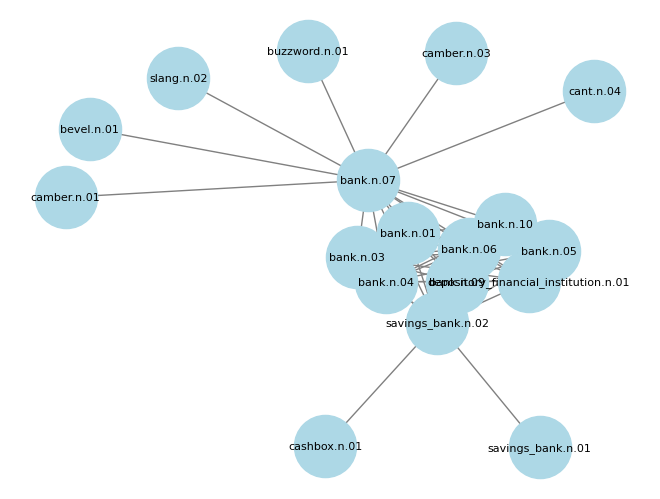

In [19]:
wn_graph.draw()